# Example 1: Synthetic Video Data

In [1]:
# !pip install git+https://github.com/sichinaga/PyDMD@sparse-mode-bopdmd-FINAL

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

from pydmd import BOPDMD, SparseBOPDMD
from pydmd.plotter import plot_summary
from pydmd.sbopdmd_utils import *

def error(actual, truth):
    """
    Compute relative error.
    """
    return np.linalg.norm(actual - truth) / np.linalg.norm(truth)

import warnings
warnings.filterwarnings("ignore")

## Part 1: Build the data set

In [2]:
# SET ALL DATA PARAMETERS:
f1 = 0.5  # frequency of mode 1
f2 = 1.0  # frequency of mode 2
f3 = 1.5  # frequency of mode 3
nx = 50  # number of pixels along the horizontal
ny = nx  # number of pixels along the vertical
nt = 1000  # number of data snapshots
dt = 0.01  # time-step size
sigma = 0.8  # noise magnitude

# Define the true DMD eigenvalues.
true_eigs = 1j * 2 * np.pi * np.array([f1, f2, f3])

# Define the spatial and temporal grid.
n = nx * ny
x = np.arange(nx)
y = np.arange(ny)
t = np.arange(nt) * dt
Xgrid, Ygrid = np.meshgrid(x, y)

# Define mode 1 (gradient mode).
u1 = np.tile(np.linspace(-1, 1, nx), (ny, 1)).T
t1 = np.exp(true_eigs[0] * t)
X1 = np.outer(u1.flatten(), t1)

# Define mode 2 (Gaussian mode).
u2 = np.exp(-(0.5 / nx) * ((Xgrid - 0.5 * nx) ** 2 + (Ygrid - 0.5 * ny) ** 2))
t2 = np.exp(true_eigs[1] * t)
X2 = np.outer(u2.flatten(), t2)

# Define mode 3 (square mode).
square_start = int(0.2 * nx)
square_end = int(0.5 * nx)
u3 = np.zeros((nx, ny))
u3[square_start:square_end, square_start:square_end] = 1.0
t3 = np.exp(true_eigs[2] * t)
X3 = np.outer(u3.flatten(), t3)

# Build data matrix.
X_clean = X1 + X2 + X3

# Add measurement noise.
rng1 = np.random.default_rng(seed=1234)
rng2 = np.random.default_rng(seed=5678)
real_noise = sigma * rng1.standard_normal((n, nt))
imag_noise = sigma * 1j * rng2.standard_normal((n, nt))
X = X_clean + real_noise + imag_noise

print("Data successfully generated!")
print(f"Data dimensions in (space, time): {X.shape}")

Data successfully generated!
Data dimensions in (space, time): (2500, 1000)


In [3]:
# Apply sparse-mode DMD (default model style)
sp_optdmd = SparseBOPDMD(
    svd_rank=3,
    SR3_step=1,
    mode_regularizer="l1",
    regularizer_params={"lambda": 0.1},
    apply_debias=True,
    index_global="auto",
).fit(X, t)

### Part 1 Figures and Videos

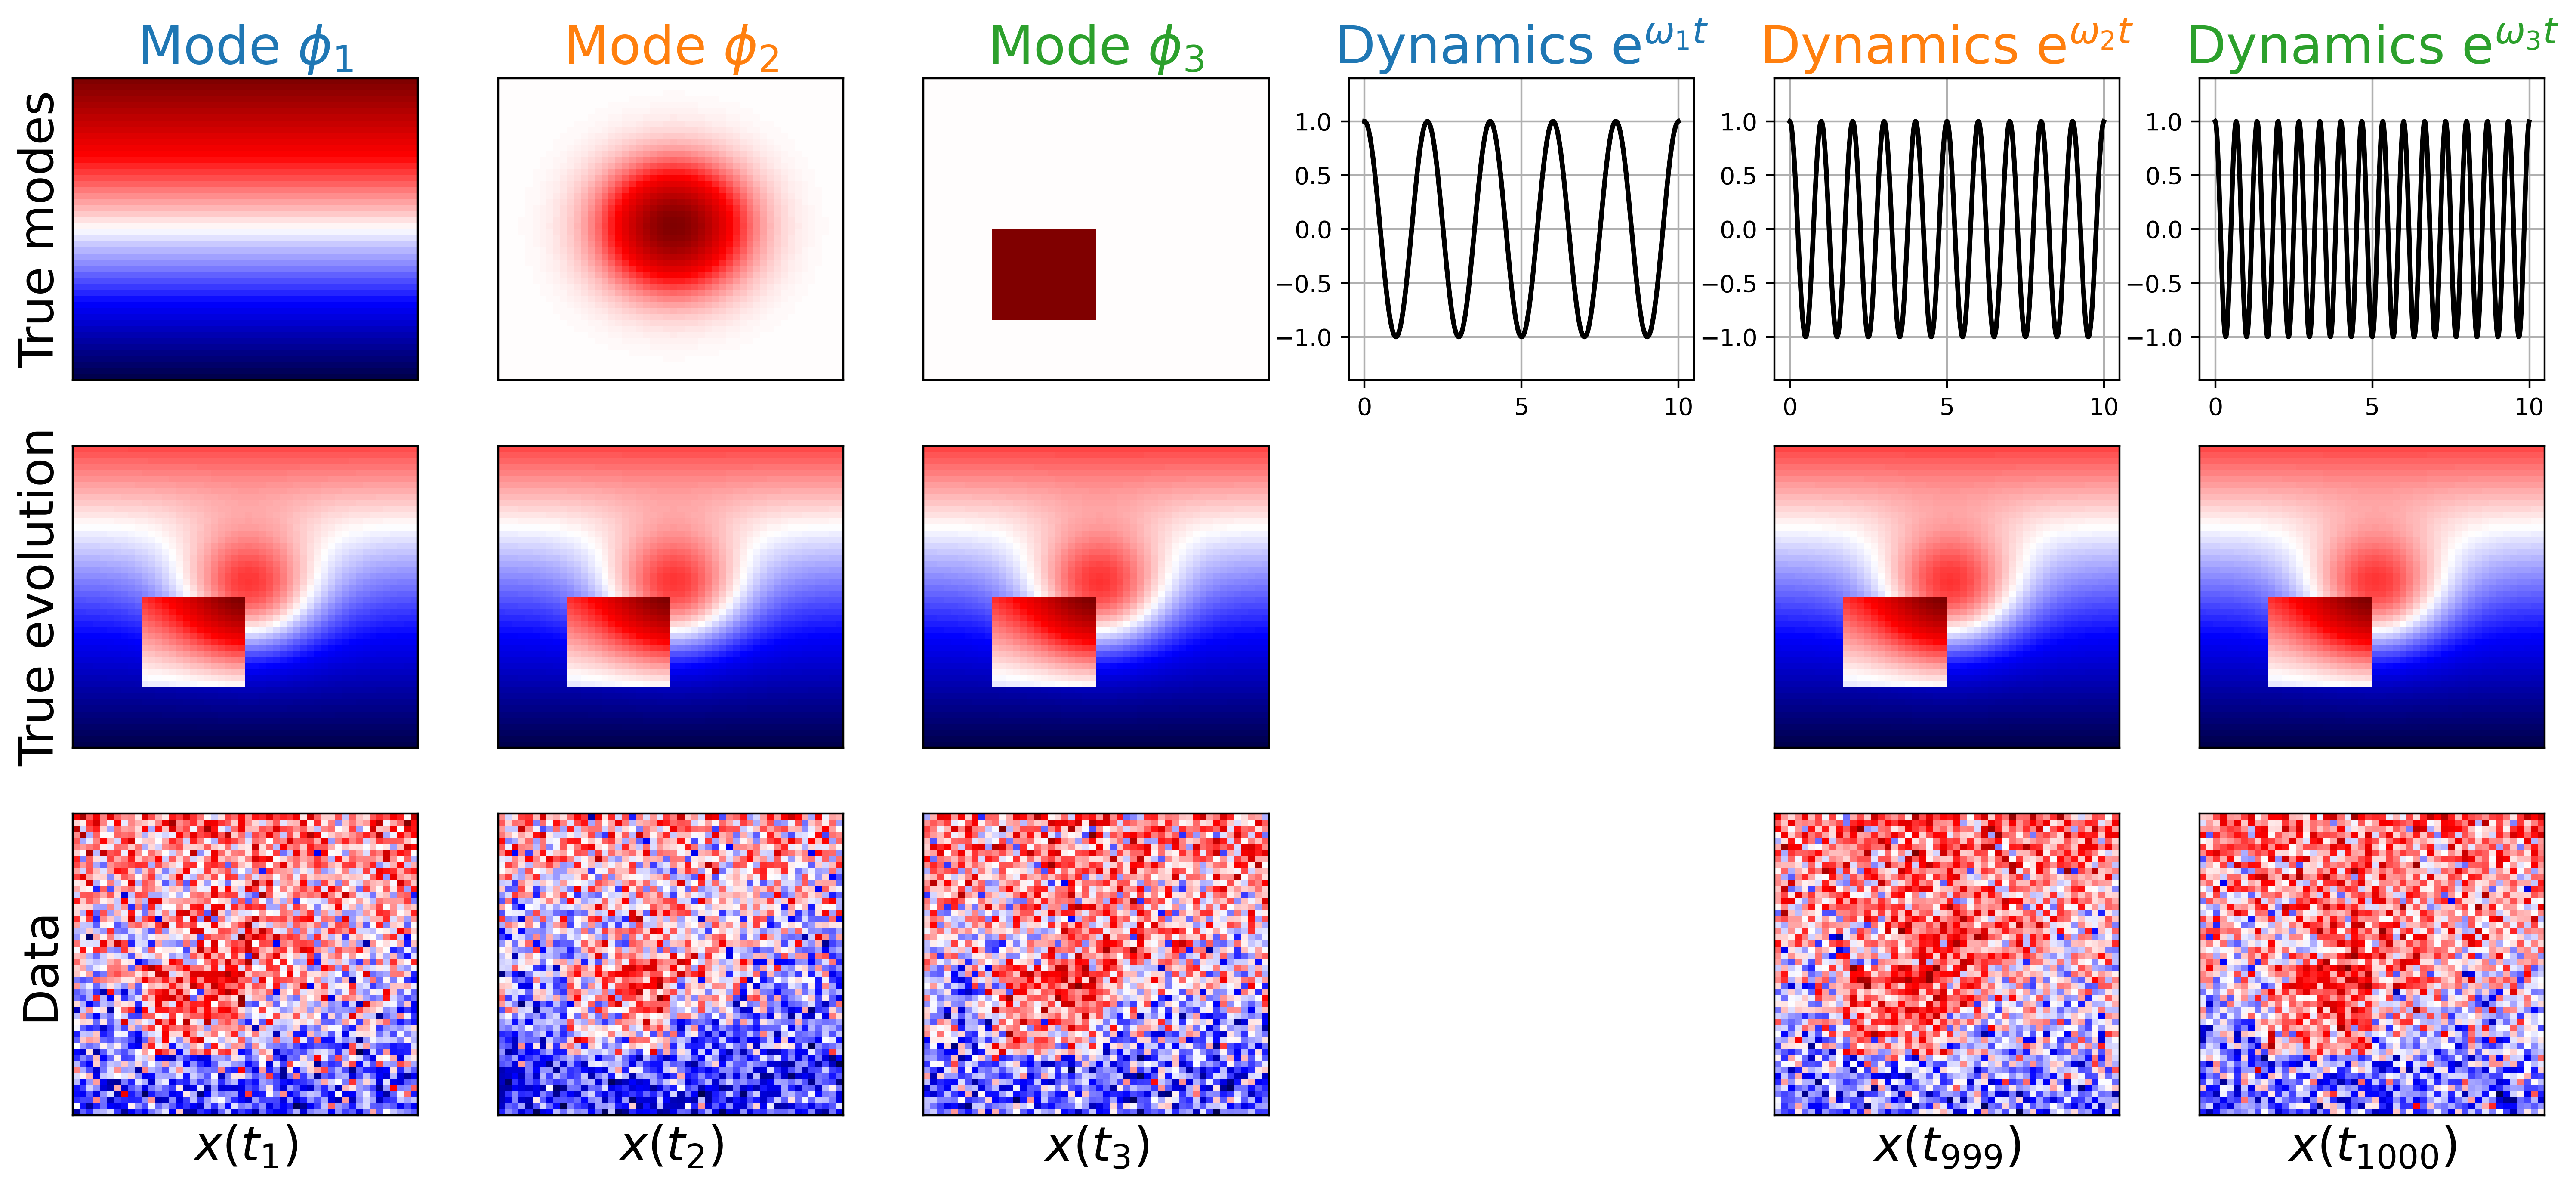

In [4]:
fig = plt.figure(figsize=(15, 7), dpi=400)
mode_colors = ["tab:blue", "tab:orange", "tab:green"]

# (1a) Plot the spatial modes.
for i, u in enumerate([u1, u2, u3]):
    ax = fig.add_subplot(3, 6, i + 1)
    ax.set_title(f"Mode $\phi_{i + 1}$", fontsize=22, c=mode_colors[i])
    ax.pcolor(u.reshape(ny, nx), vmax=1, vmin=-1, cmap="seismic")
    ax.set_xticks([])
    ax.set_yticks([])

    if i == 0:
        ax.set_ylabel("True modes", fontsize=20)

# (1b) Plot the time dynamics.
dynamics_titles = [
    "Dynamics e$^{\omega_1 t}$",
    "Dynamics e$^{\omega_2 t}$",
    "Dynamics e$^{\omega_3 t}$"
]
for i, dynamics in enumerate([t1, t2, t3]):
    ax = fig.add_subplot(3, 6, i + 4)
    ax.set_title(dynamics_titles[i], fontsize=22, c=mode_colors[i])
    ax.plot(t, dynamics.real, lw=2, c="k")
    ax.set_ylim([-1.4, 1.4])
    ax.grid()
    ax.tick_params(axis="both", which="major", labelsize=10)

# (2) Plot the clean data.
for i, x in enumerate(np.hstack([X_clean[:, :3], X_clean[:, -3:]]).T):
    if i == 3:
        ax = fig.add_subplot(3, 6, i + 7)
        ax.axis("off")
    else:
        ax = fig.add_subplot(3, 6, i + 7)
        plt.pcolor(x.reshape(ny, nx).real, cmap="seismic")

    if i == 0:
        ax.set_ylabel("True evolution", fontsize=20)

    ax.set_xticks([])
    ax.set_yticks([])

# (3) Plot the noisy data.
snapshot_titles = ["$x(t_{1})$", "$x(t_{2})$", "$x(t_{3})$", "", "$x(t_{999})$", "$x(t_{1000})$"]
for i, x in enumerate(np.hstack([X[:, :3], X[:, -3:]]).T):
    if i == 3:
        ax = fig.add_subplot(3, 6, i + 13)
        ax.axis("off")
    else:
        ax = fig.add_subplot(3, 6, i + 13)
        ax.set_xlabel(snapshot_titles[i], fontsize=20)
        plt.pcolor(x.reshape(ny, nx).real, cmap="seismic")

    if i == 0:
        ax.set_ylabel("Data", fontsize=20)

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

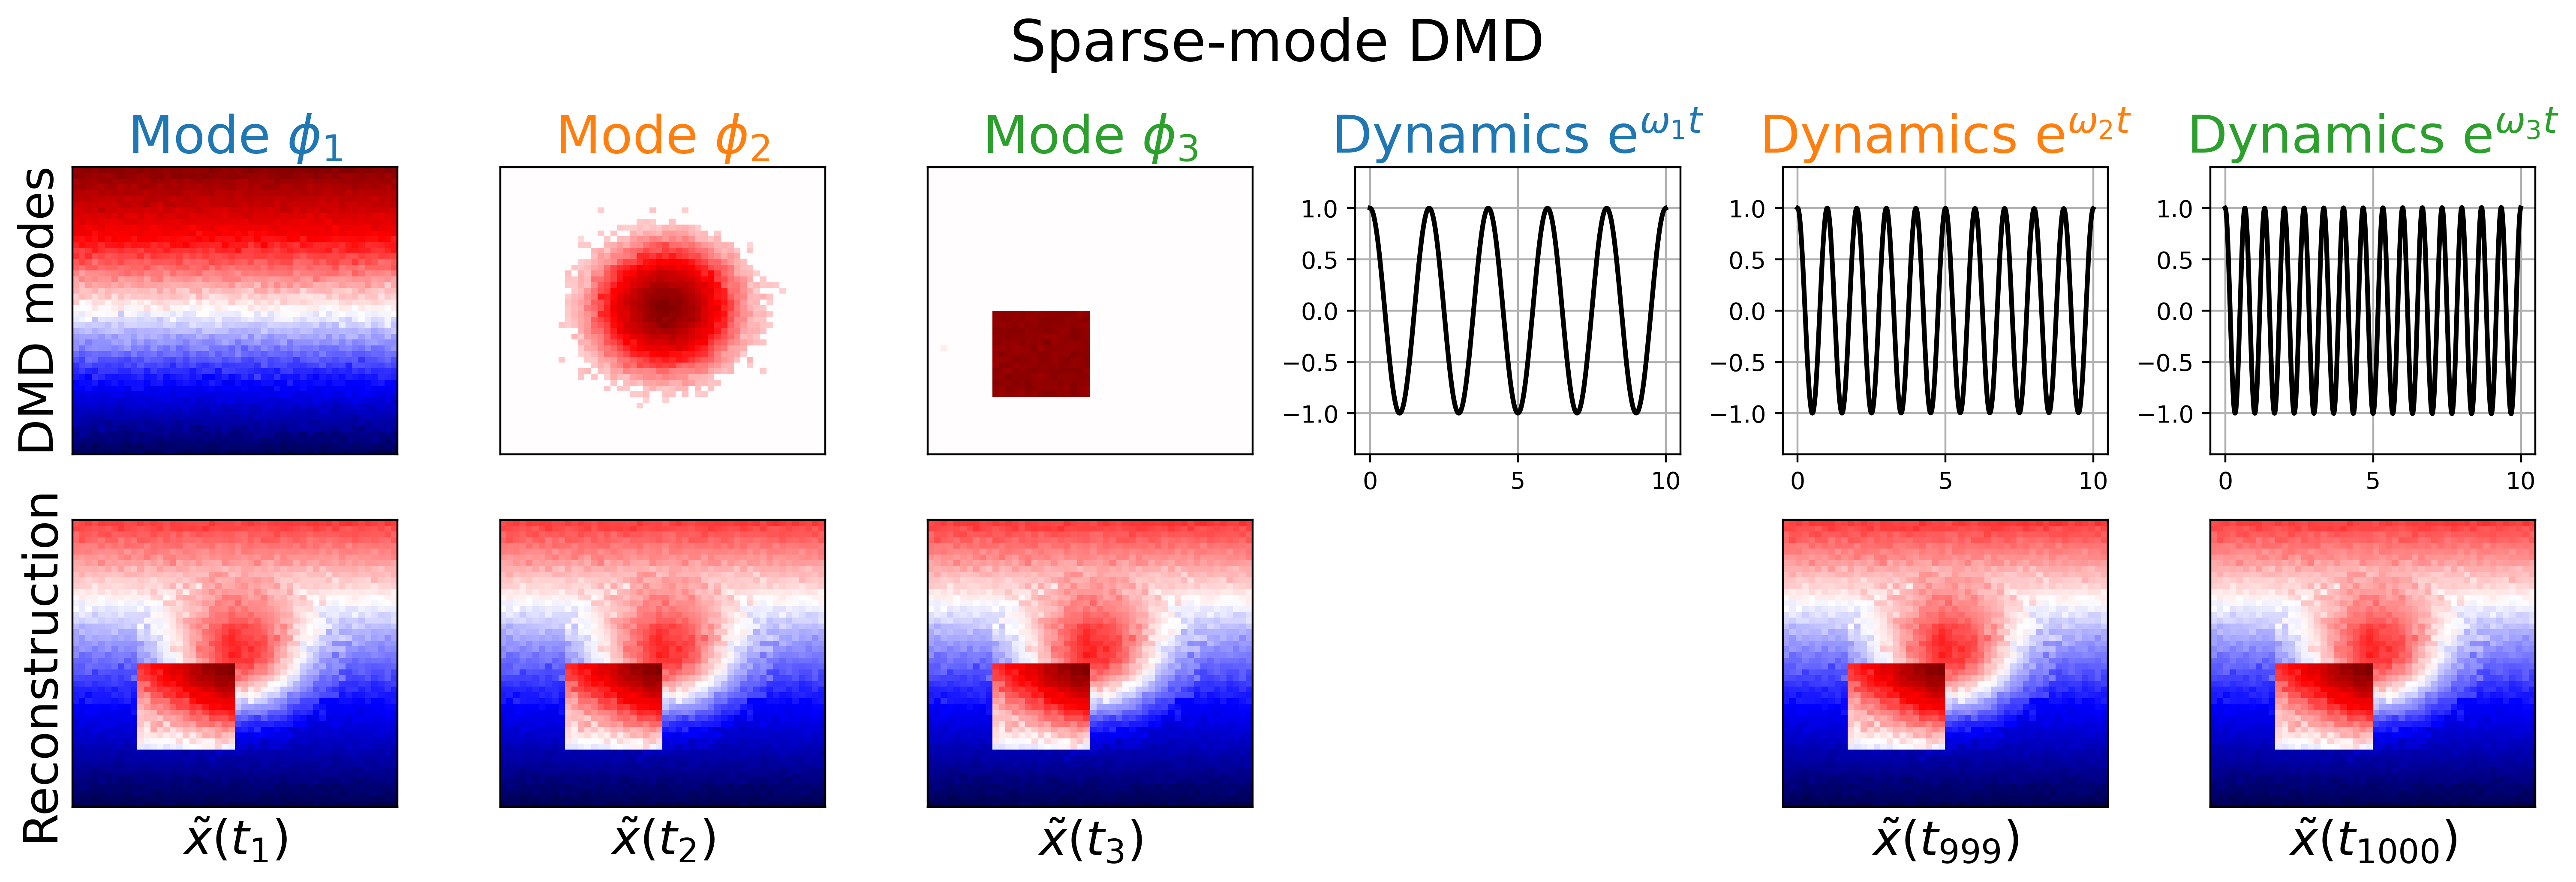

In [5]:
fig = plt.figure(figsize=(15, 5.2), dpi=400)

plt.suptitle("Sparse-mode DMD", fontsize=24)

# (4) Plot sparse-mode DMD modes and dynamics.
# Iterate through the gradient, gaussian, and square.
for true_idx, dmd_idx in enumerate([0, 2, 1]):

    # Get the current mode and corresponding dynamics.
    mode = sp_optdmd.modes[:, dmd_idx]
    vmax = np.abs(mode).max()
    dynamics = np.exp(sp_optdmd.eigs[dmd_idx] * t)
    true_dynamics = np.exp(true_eigs[true_idx] * t)

    # (4a) Plot the DMD mode.
    ax = fig.add_subplot(2, 6, true_idx + 1)
    ax.set_title(f"Mode $\phi_{true_idx + 1}$", fontsize=22, c=mode_colors[true_idx])
    ax.pcolor(
        mode.reshape(ny, nx).real,
        vmax=vmax,
        vmin=-vmax,
        cmap="seismic",
    )

    if true_idx == 0:
        ax.set_ylabel("DMD modes", fontsize=20)

    ax.set_xticks([])
    ax.set_yticks([])

    # (4b) Plot the DMD dynamics.
    ax = fig.add_subplot(2, 6, true_idx + 4)
    ax.set_title(dynamics_titles[true_idx], fontsize=22, c=mode_colors[true_idx])
    ax.plot(t, dynamics, c="k", lw=2)
    ax.set_ylim([-1.4, 1.4])
    ax.grid()

# (5) Plot sparse-mode DMD data reconstruction.
recon_titles = [
    "$\\tilde{x}(t_{1})$",
    "$\\tilde{x}(t_{2})$",
    "$\\tilde{x}(t_{3})$",
    "",
    "$\\tilde{x}(t_{999})$",
    "$\\tilde{x}(t_{1000})$",
]
for i, x in enumerate(np.hstack([sp_optdmd.reconstructed_data[:, :3], sp_optdmd.reconstructed_data[:, -3:]]).T):
    if i == 3:
        ax = fig.add_subplot(2, 6, i + 7)
        ax.axis("off")
    else:
        ax = fig.add_subplot(2, 6, i + 7)
        ax.set_xlabel(recon_titles[i], fontsize=20)
        plt.pcolor(x.reshape(ny, nx).real, cmap="seismic")

    if i == 0:
        ax.set_ylabel("Reconstruction", fontsize=20)

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## Part 2: Apply DMD

In [6]:
# (1) Optimized DMD.
optdmd = BOPDMD(svd_rank=3).fit(X, t)

# (2) Sparse-mode DMD with l1 norm.
optdmd_l1 = SparseBOPDMD(
    svd_rank=3,
    SR3_step=0,
    mode_regularizer="l1",
    regularizer_params={"lambda": 100.0},
).fit(X, t)

# (3) Sparse-mode DMD with l0 norm.
optdmd_l0 = SparseBOPDMD(
    svd_rank=3,
    SR3_step=0,
    mode_regularizer="l0",
    regularizer_params={"lambda": 10.0},
).fit(X, t)

# (4) Sparse-mode DMD with SR3 + de-biasing.
optdmd_sr3 = SparseBOPDMD(
    svd_rank=3,
    SR3_step=1,
    mode_regularizer="l1",
    regularizer_params={"lambda": 0.1},
    apply_debias=True,
).fit(X, t)

### Part 2 Figures and Videos

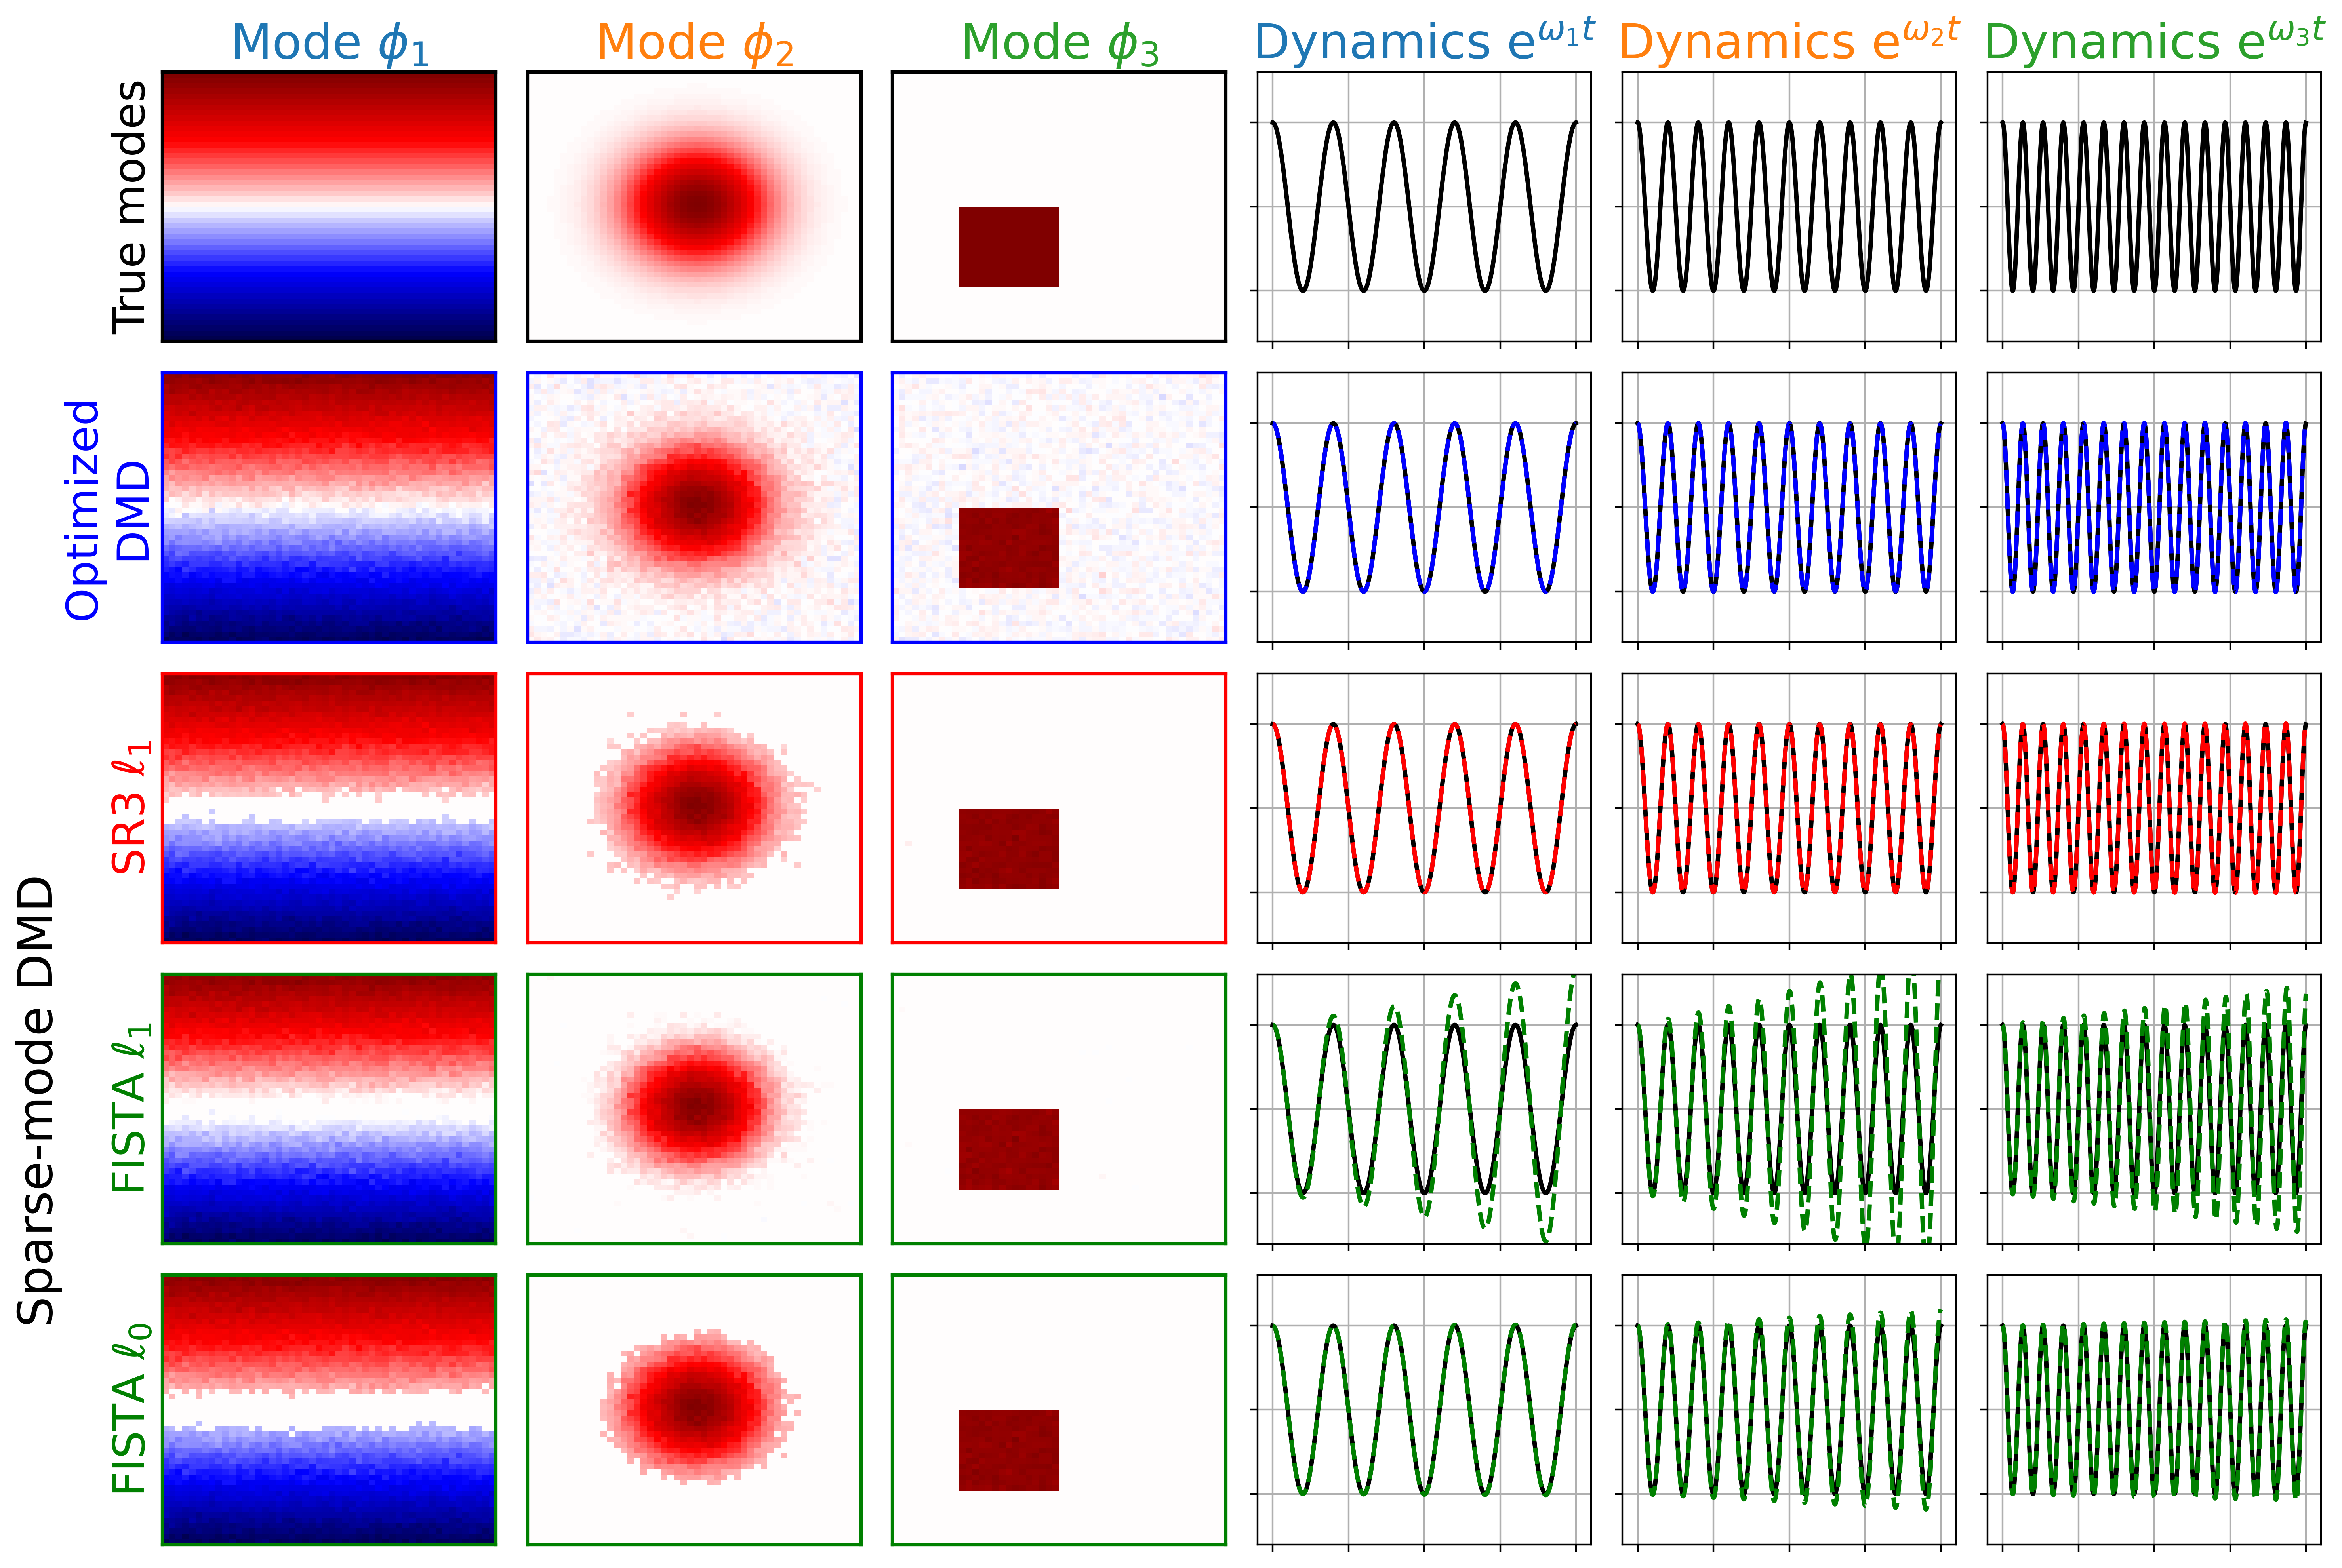

In [7]:
true_colors = ["tab:blue", "tab:orange", "tab:green"]
figure_labels = [
    "Optimized\nDMD",
    "SR3 $\ell_1$",
    "FISTA $\ell_1$",
    "FISTA $\ell_0$",
]
all_models = [optdmd, optdmd_sr3, optdmd_l1, optdmd_l0]
model_colors = ["b", "r", "g", "g"]

fig = plt.figure(figsize=(15, 10), dpi=400)

for i, u in enumerate([u1, u2, u3]):
    ax = fig.add_subplot(5, 6, i + 1)
    ax.set_title(f"Mode $\phi_{i + 1}$", fontsize=22, c=mode_colors[i])
    ax.pcolor(u.reshape(ny, nx), vmax=1, vmin=-1, cmap="seismic")
    ax.set_xticks([])
    ax.set_yticks([])
    for location in ["left", "right", "top", "bottom"]:
        ax.spines[location].set_linewidth(1.5)

    if i == 0:
        ax.set_ylabel("True modes", fontsize=20)

dynamics_titles = [
    "Dynamics e$^{\omega_1 t}$",
    "Dynamics e$^{\omega_2 t}$",
    "Dynamics e$^{\omega_3 t}$"
]
for i, dynamics in enumerate([t1, t2, t3]):
    ax = fig.add_subplot(5, 6, i + 4)
    ax.set_title(dynamics_titles[i], fontsize=22, c=mode_colors[i])
    ax.plot(t, dynamics.real, lw=2, c="k")
    ax.set_ylim([-1.6, 1.6])
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Plot the modes and dynamics for each DMD model.
for model_idx, model in enumerate(all_models):

    # Iterate through the gradient, gaussian, and square.
    for true_idx, dmd_idx in enumerate([0, 2, 1]):

        # Get the current mode and corresponding dynamics.
        mode = model.modes[:, dmd_idx]
        vmax = np.abs(mode).max()
        dynamics = np.exp(model.eigs[dmd_idx] * t)
        true_dynamics = np.exp(true_eigs[true_idx] * t)

        # Plot the DMD mode.
        ax = fig.add_subplot(5, 6, 6 * (model_idx + 1) + true_idx + 1)
        ax.pcolor(
            mode.reshape(ny, nx).real,
            vmax=vmax,
            vmin=-vmax,
            cmap="seismic",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        plt.setp(ax.spines.values(), color=model_colors[model_idx])
        for location in ["left", "right", "top", "bottom"]:
            ax.spines[location].set_linewidth(1.5)

        if true_idx == 0:
            # Add label to the first mode.
            ax.set_ylabel(figure_labels[model_idx], fontsize=20, c=model_colors[model_idx])

        # Plot the DMD dynamics against the true dynamics.
        ax = fig.add_subplot(5, 6, 6 * (model_idx + 1) + true_idx + 4)
        ax.plot(t, true_dynamics, c="k", lw=2)
        ax.plot(t, dynamics, "--", c=model_colors[model_idx], lw=2)
        ax.set_ylim([-1.6, 1.6])
        ax.grid(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

fig.supylabel("Sparse-mode DMD",fontsize=22, y=0.3, c="k")
plt.tight_layout()
plt.show()

In [8]:
models = [optdmd_sr3, optdmd_l1, optdmd_l0]
model_names = [
    "Sparse-mode DMD (SR3)",
    "Sparse-mode DMD (FISTA l1)",
    "Sparse-mode DMD (FISTA l0)",
]

for model, model_name in zip(models, model_names):
    print(f"{model_name} results:")
    print(f"{len(model.operator._obj_history)} variable projection iterations.")

    avg_iter = np.average([len(x) for x in model.operator._obj_history])
    print(f"{avg_iter} mode update iterations on average.")

    print(f"Model Error = {np.round(100 * error(model.reconstructed_data, X_clean), decimals=4)}%")
    print()

Sparse-mode DMD (SR3) results:
6 variable projection iterations.
4.0 mode update iterations on average.
Model Error = 7.2983%

Sparse-mode DMD (FISTA l1) results:
6 variable projection iterations.
10.333333333333334 mode update iterations on average.
Model Error = 20.1823%

Sparse-mode DMD (FISTA l0) results:
24 variable projection iterations.
6.833333333333333 mode update iterations on average.
Model Error = 8.9872%



## Part 3: Compare sparse models

In [9]:
# Choose the lambda values to examine.
lambda_vals = np.linspace(0.01, 0.15, 100)

# Store model errors and amplitude-scaled modes.
errors = np.empty(len(lambda_vals))
all_modes = []
errors_gl = np.empty(len(lambda_vals))
all_modes_gl = []

# Set the shared model parameters.
model_params = {}
model_params["svd_rank"] = 4
model_params["SR3_step"] = 1
model_params["mode_regularizer"] = "l1"
model_params["apply_debias"] = True

for i, _lambda in tqdm(enumerate(lambda_vals)):
    # Fit model without global-local split.
    optdmd_sparse = SparseBOPDMD(
        regularizer_params={"lambda": _lambda},
        **model_params,
    ).fit(X, t)
    errors[i] = error(optdmd_sparse.reconstructed_data, X_clean)
    all_modes.append(optdmd_sparse.modes.dot(np.diag(optdmd_sparse.amplitudes)))

    # Fit model with global-local split.
    optdmd_gl = SparseBOPDMD(
        regularizer_params={"lambda": _lambda},
        index_global="auto",
        **model_params,
    ).fit(X, t)
    errors_gl[i] = error(optdmd_gl.reconstructed_data, X_clean)
    all_modes_gl.append(optdmd_gl.modes.dot(np.diag(optdmd_gl.amplitudes)))


100it [12:22,  7.43s/it]


### Part 3 Figures and Videos

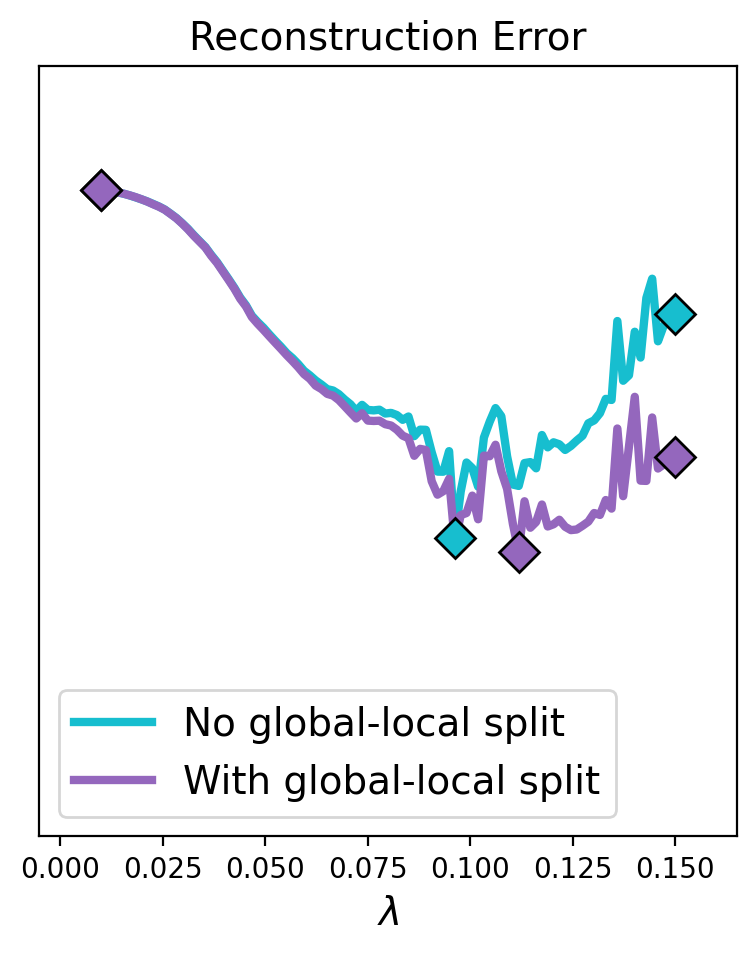

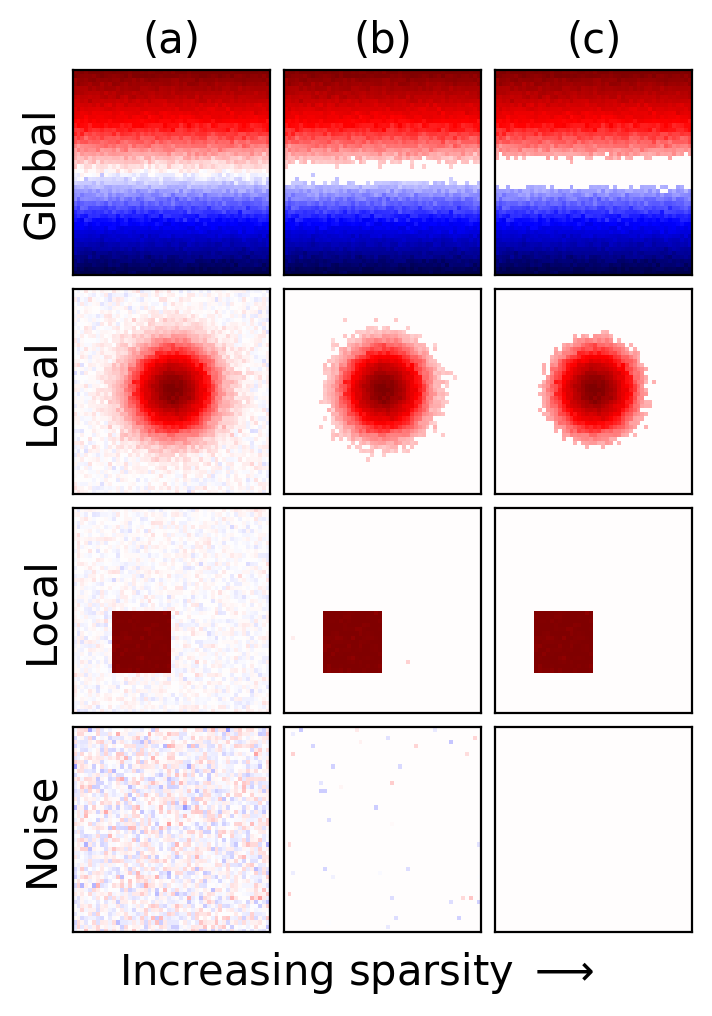

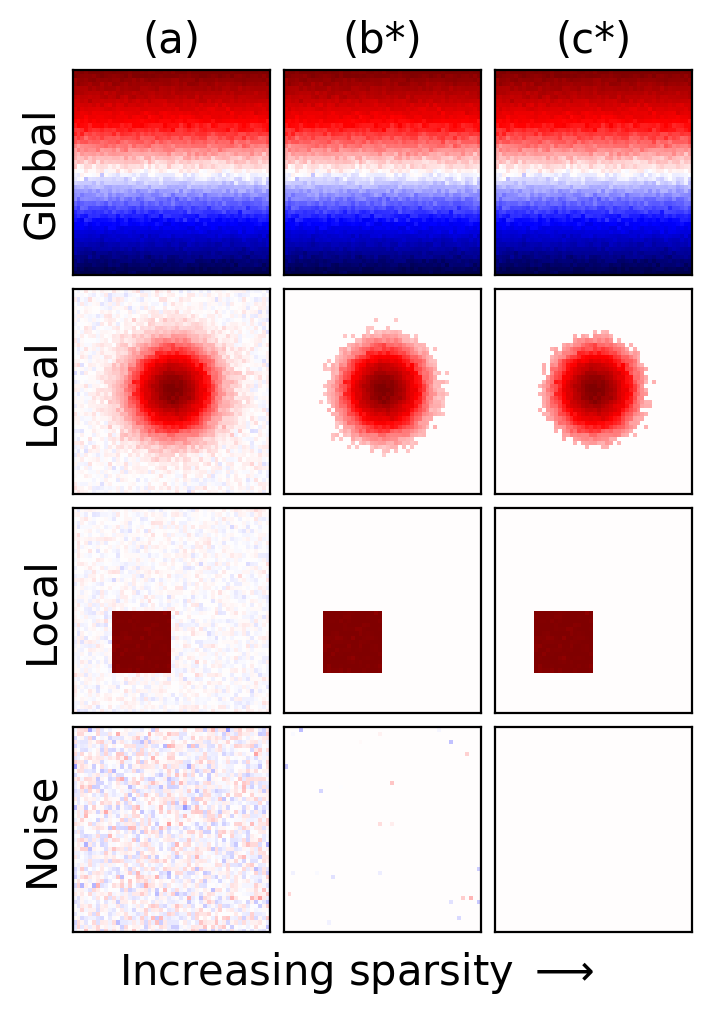

In [10]:
record_idx = [0, np.argmin(errors), len(lambda_vals) - 1]
record_idx_gl = [0, np.argmin(errors_gl), len(lambda_vals) - 1]

# (1) Plot error.
plt.figure(figsize=(4.5, 5), dpi=200)
plt.plot(lambda_vals, errors, c="tab:cyan", lw=3, label="No global-local split")
plt.plot(lambda_vals, errors_gl, c="tab:purple", lw=3, label="With global-local split")

for idx in record_idx:
    plt.plot(lambda_vals[idx], errors[idx], "D", mec="k", mfc="tab:cyan", ms=10)

for idx in record_idx_gl:
    plt.plot(lambda_vals[idx], errors_gl[idx], "D", mec="k", mfc="tab:purple", ms=10)

plt.title("Reconstruction Error", fontsize=14)
plt.xlabel("$\lambda$", fontsize=14)
plt.legend(loc="lower left", fontsize=14)
plt.xlim([lambda_vals.min() - 0.015, lambda_vals.max() + 0.015])
plt.ylim([0.05, 0.11])
plt.yticks([])
plt.show()

# (2) Plot modes without global-local:
plot_titles = ["(a)", "(b)", "(c)"]
plot_titles_gl = ["(a)", "(b*)", "(c*)"]
plot_labels = ["Global", "Local", "Local", "Noise"]

for k in range(2):
    record_idx_k = [record_idx, record_idx_gl][k]
    all_modes_k = [all_modes, all_modes_gl][k]
    plot_titles_k = [plot_titles, plot_titles_gl][k]

    fig = plt.figure(figsize=(3.5, 5), dpi=200)
    for i, idx in enumerate(record_idx_k):
        mode_set = all_modes_k[idx]
        for j, mode_idx in enumerate([0, 3, 2, 1]):
            mode = mode_set[:, mode_idx]
            plt.subplot(mode_set.shape[1], len(record_idx), len(record_idx) * j + i + 1)
            plt.pcolor(mode.reshape(ny, nx).real, vmax=1, vmin=-1, cmap="seismic")
            plt.xticks([])
            plt.yticks([])
            if j == 0:
                plt.title(plot_titles_k[i], fontsize=15)
            if i == 0:
                plt.ylabel(plot_labels[j], fontsize=15)

    fig.supxlabel("Increasing sparsity $\longrightarrow$", fontsize=15)
    plt.tight_layout(pad=0.5)
    plt.show()
